In [1]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from jenkspy import JenksNaturalBreaks

from src.clustering import SingleDimensionalClustererFinder, SklearnSingleDimensionalClustererFinder

In [2]:
data = pd.read_excel("../data/raw/ROS1_all data randomised.xlsx")
series = data["VALUE"].to_numpy()

### 1. Finding best clustering parameters using Davies-Boulding metric

Initialize Clusterer Finders

In [3]:
negated_davies_boulding = lambda *args, **kwargs: -metrics.davies_bouldin_score(*args, **kwargs)

class JenksNaturalBreaksAdjusted(JenksNaturalBreaks): 
    def set_params(self, n_classes: int) -> None:
        self.n_classes = n_classes

    def fit_predict(self, data: np.ndarray) -> np.ndarray:
        self.fit(data)
        return self.labels_

fj_params = ParameterGrid({"n_classes": range(2, 16)})
kmeans_params = ParameterGrid({"n_clusters": range(2, 16), "random_state": [35]})

kmeans_clusterer_finder = SklearnSingleDimensionalClustererFinder(
    param_grid=kmeans_params, 
    scoring_function=negated_davies_boulding,
    clusterer=KMeans(n_clusters=2)
)

fj_clusterer_finder = SingleDimensionalClustererFinder(
    param_grid=fj_params, 
    scoring_function=negated_davies_boulding,
    clusterer=JenksNaturalBreaksAdjusted(n_classes=2),
)

In [4]:
best_km_prediction = kmeans_clusterer_finder.cluster_data_series(series, verbose=True)

Params: {'n_clusters': 2, 'random_state': 35} | Score: -0.37598351008126657
Params: {'n_clusters': 3, 'random_state': 35} | Score: -0.3162188258549096
Params: {'n_clusters': 4, 'random_state': 35} | Score: -0.29841483042114536
Params: {'n_clusters': 5, 'random_state': 35} | Score: -0.36134987718761497
Params: {'n_clusters': 6, 'random_state': 35} | Score: -0.4330617487902802
Params: {'n_clusters': 7, 'random_state': 35} | Score: -0.4403377186471929
Params: {'n_clusters': 8, 'random_state': 35} | Score: -0.4498677415942919
Params: {'n_clusters': 9, 'random_state': 35} | Score: -0.4872832582455115
Params: {'n_clusters': 10, 'random_state': 35} | Score: -0.48507687897531976
Params: {'n_clusters': 11, 'random_state': 35} | Score: -0.46011679429776825
Params: {'n_clusters': 12, 'random_state': 35} | Score: -0.4712599580265782
Params: {'n_clusters': 13, 'random_state': 35} | Score: -0.4845318547892662
Params: {'n_clusters': 14, 'random_state': 35} | Score: -0.490745977588149
Params: {'n_clus

In [5]:
best_fj_labels = fj_clusterer_finder.cluster_data_series(series, verbose=True)

Params: {'n_classes': 2} | Score: -0.37598351008126657
Params: {'n_classes': 3} | Score: -0.3162188258549096
Params: {'n_classes': 4} | Score: -0.29841483042114536
Params: {'n_classes': 5} | Score: -0.36134987718761497
Params: {'n_classes': 6} | Score: -0.43231352897206454
Params: {'n_classes': 7} | Score: -0.43846397467181436
Params: {'n_classes': 8} | Score: -0.4484094220229851
Params: {'n_classes': 9} | Score: -0.4850329609275846
Params: {'n_classes': 10} | Score: -0.48622355783959376
Params: {'n_classes': 11} | Score: -0.46198139731521065
Params: {'n_classes': 12} | Score: -0.4718003826162611
Params: {'n_classes': 13} | Score: -0.4778251755779604
Params: {'n_classes': 14} | Score: -0.4874272386423602
Params: {'n_classes': 15} | Score: -0.4893154156105687

DONE

Best Score: -0.29841483042114536
Best Params: {'n_classes': 4}


Both Clusterer finders converge to the same prediction:

In [6]:
all(best_fj_labels == best_km_prediction)

True

Below we can see sizes of the clusters:

In [7]:
for label in set(best_fj_labels):
    print(f"Group {label}: {sum(best_fj_labels == label):>4} elements")

Group 0: 1738 elements
Group 1: 4896 elements
Group 2:   41 elements
Group 3:   13 elements


Different visualizations of clusters (intervals). Red lines denote breaks between different clusters.

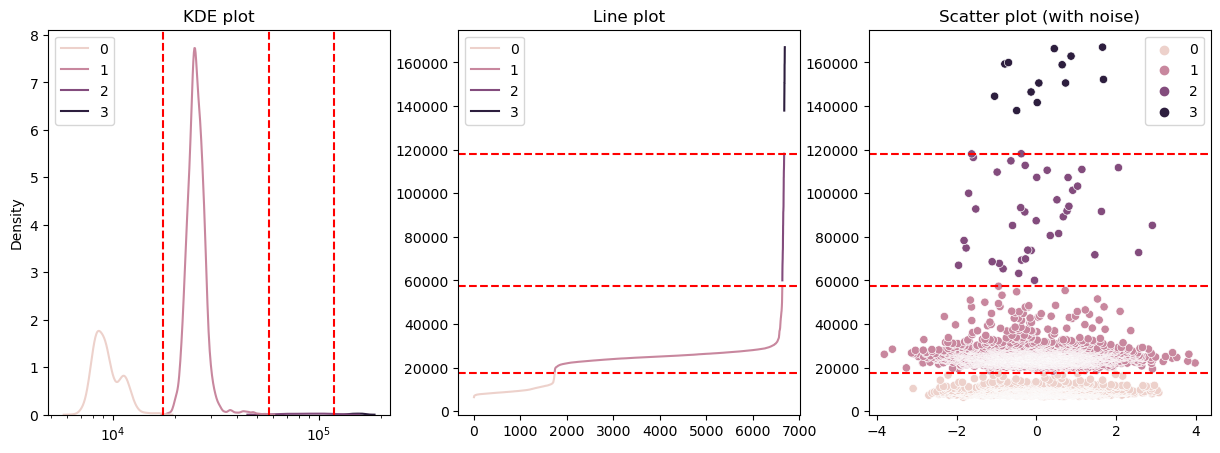

In [8]:
sorted_series = np.sort(series)
breaks = fj_clusterer_finder.best_clusterer.breaks_[1:-1]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(x=sorted_series, hue=best_fj_labels ,ax=ax[0], log_scale=True).set_title("KDE plot")
sns.lineplot(x=range(len(series)), y=sorted_series, hue=best_fj_labels ,ax=ax[1]).set_title("Line plot")
sns.scatterplot(x=np.random.normal(size=(len(series), )), y=sorted_series, hue=best_fj_labels ,ax=ax[2]).set_title("Scatter plot (with noise)")
for b in breaks:
    ax[0].axvline(x=b, color='r', linestyle='--')
    ax[1].axhline(y=b, color='r', linestyle='--')
    ax[2].axhline(y=b, color='r', linestyle='--')
plt.show()

We can see that the group denoted by '1' is by far the most numerous.
Group '0' seems to have two local maxima.

KDE plot of the last two groups - distribution does not seem to be normal (probably due to small size of these 2 clusters)

Text(0.5, 1.0, 'KDE plot - focus on last 2 groups')

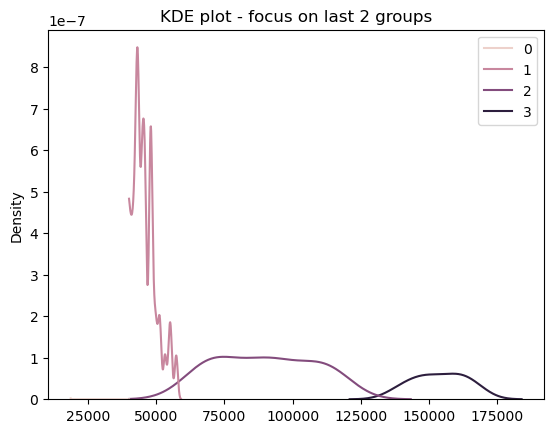

In [9]:
sns.kdeplot(x=sorted_series, hue=best_fj_labels , log_scale=False, clip=(40_000, 200_000)).set_title("KDE plot - focus on last 2 groups")

### 2. Finding best clustering parameters using Silhouette metric

In [10]:
kmeans_clusterer_finder = SklearnSingleDimensionalClustererFinder(
    param_grid=kmeans_params, 
    scoring_function=metrics.silhouette_score,
    clusterer=KMeans(n_clusters=2)
)

fj_clusterer_finder = SingleDimensionalClustererFinder(
    param_grid=fj_params, 
    scoring_function=metrics.silhouette_score,
    clusterer=JenksNaturalBreaksAdjusted(n_classes=2),
)

In [11]:
best_km_prediction = kmeans_clusterer_finder.cluster_data_series(series, verbose=True)

Params: {'n_clusters': 2, 'random_state': 35} | Score: 0.9046650035322498
Params: {'n_clusters': 3, 'random_state': 35} | Score: 0.8335119131501095
Params: {'n_clusters': 4, 'random_state': 35} | Score: 0.835218835226262
Params: {'n_clusters': 5, 'random_state': 35} | Score: 0.8382582096348212
Params: {'n_clusters': 6, 'random_state': 35} | Score: 0.6356008994722809
Params: {'n_clusters': 7, 'random_state': 35} | Score: 0.6372659727498718
Params: {'n_clusters': 8, 'random_state': 35} | Score: 0.6132240201043159
Params: {'n_clusters': 9, 'random_state': 35} | Score: 0.5607751638061009
Params: {'n_clusters': 10, 'random_state': 35} | Score: 0.5724683281129647
Params: {'n_clusters': 11, 'random_state': 35} | Score: 0.5714860820961398
Params: {'n_clusters': 12, 'random_state': 35} | Score: 0.5619395413696702
Params: {'n_clusters': 13, 'random_state': 35} | Score: 0.5624341036496997
Params: {'n_clusters': 14, 'random_state': 35} | Score: 0.5554616793128768
Params: {'n_clusters': 15, 'random

In [12]:
best_fj_labels = fj_clusterer_finder.cluster_data_series(series, verbose=True)

Params: {'n_classes': 2} | Score: 0.9046650035322498
Params: {'n_classes': 3} | Score: 0.8335119131501095
Params: {'n_classes': 4} | Score: 0.835218835226262
Params: {'n_classes': 5} | Score: 0.8382582096348212
Params: {'n_classes': 6} | Score: 0.635746085903982
Params: {'n_classes': 7} | Score: 0.6373572289021016
Params: {'n_classes': 8} | Score: 0.6147339309856399
Params: {'n_classes': 9} | Score: 0.5631426374283348
Params: {'n_classes': 10} | Score: 0.573091546649468
Params: {'n_classes': 11} | Score: 0.5731308401551142
Params: {'n_classes': 12} | Score: 0.562587651080755
Params: {'n_classes': 13} | Score: 0.5558242361880928
Params: {'n_classes': 14} | Score: 0.5556909334327585
Params: {'n_classes': 15} | Score: 0.56319867485543

DONE

Best Score: 0.9046650035322498
Best Params: {'n_classes': 2}


Once again both finders converge to the same prediction. Silhouette score was the best for only 2 groups.

In [13]:
all(best_fj_labels == best_km_prediction)

True

We can observe very high imbalance in the sizes of the two groups - outliers seem to have all been put to a single cluster.

In [14]:
for label in set(best_fj_labels):
    print(f"Group {label}: {sum(best_fj_labels == label):>4} elements")

Group 0: 6636 elements
Group 1:   52 elements


Visualization analogous to the one for DB score

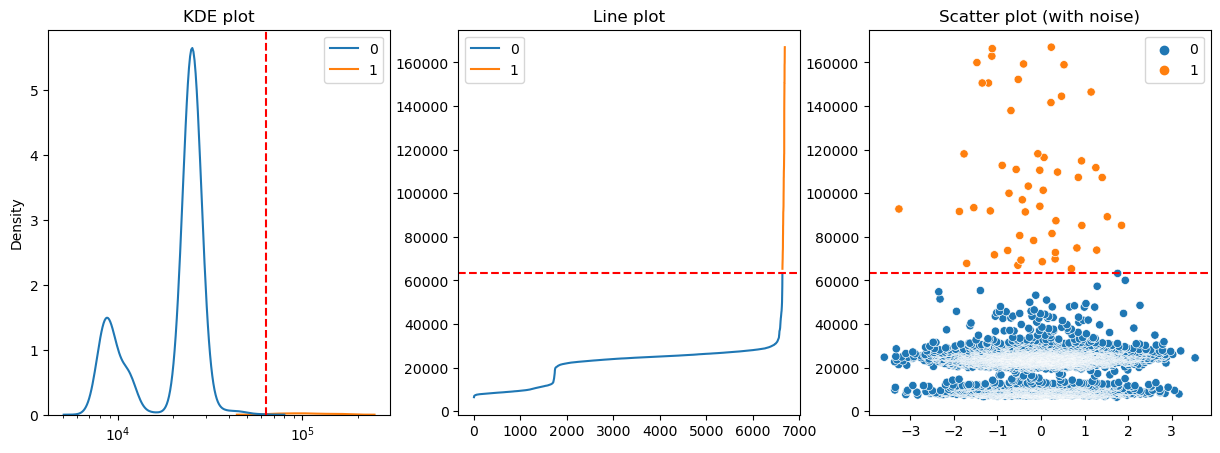

In [15]:
sorted_series = np.sort(series)
breaks = fj_clusterer_finder.best_clusterer.breaks_[1:-1]
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(x=sorted_series, hue=best_fj_labels ,ax=ax[0], log_scale=True).set_title("KDE plot")
sns.lineplot(x=range(len(series)), y=sorted_series, hue=best_fj_labels ,ax=ax[1]).set_title("Line plot")
sns.scatterplot(x=np.random.normal(size=(len(series), )), y=sorted_series, hue=best_fj_labels ,ax=ax[2]).set_title("Scatter plot (with noise)")
for b in breaks:
    ax[0].axvline(x=b, color='r', linestyle='--')
    ax[1].axhline(y=b, color='r', linestyle='--')
    ax[2].axhline(y=b, color='r', linestyle='--')
plt.show()

Overlapping region on KDE plot is due to smoothing.
Group '0' contains the vast majority of the examples.

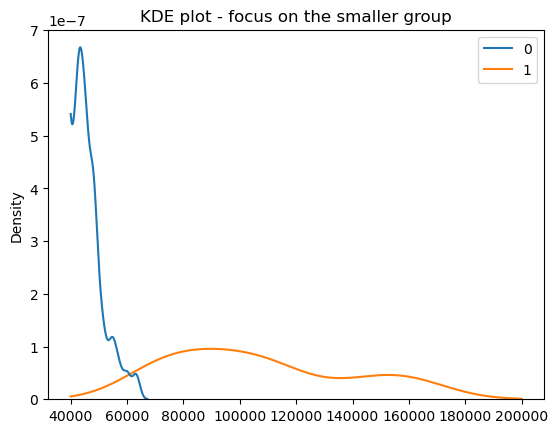

In [16]:
sns.kdeplot(x=sorted_series, hue=best_fj_labels , log_scale=False, clip=(40_000, 200_000)).set_title("KDE plot - focus on the smaller group")
plt.show()

### 3. Conclusion

- DB score seems to better suit our dataset due to its higher resiliance to outliers which there are a plenty of in the dataset.
- Outliers as well as the main body are both split into two groups according to DB score. 
- First group seem to also be splittable into two groups (as visible on KDE plot for DB score).
- Silhouette score could provide some better insight if data is stripped of the outliers.